In [136]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

In [137]:
# Ref : https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


In [138]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center",fontsize=7)
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [139]:
def plot_grid(V,ax):
    # Hide axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.table(cellText=V, loc='center',bbox=None)

In [170]:
def get_nav_actions(nav):
    n = np.chararray((100),unicode=True)
    for state in range(100):
        if(nav[state] == 0):
            n[state] = u'\u2190'
        if(nav[state] == 1):
            n[state] = u'\u2191'
        if(nav[state] == 2):
            n[state] = u'\u2192'
        if(nav[state] == 3):
            n[state] = u'\u2193'
    return n

In [140]:
A = [-10, -1, 10, 1]

In [141]:
def transition_prob(w):

    P_a = np.zeros((100, 100, 4))
    
    for k in range(0,4):
        for state in range(0,100):
            #for each state , iterate through all 4 actions 'K'   
            for k in range(0,4):
                c_case = 0
                #iterate through all directions for a given actions
                for t in range (0,4):
                    #new X, y for the desired action cell
                    s_ = state + A[t]
                    if s_ < 0 or s_ > 99 or (state % 10 == 0 and s_ % 10 == 9) or (state % 10 == 9 and s_ % 10 == 0):
                        if t == k:
                            #I want to drift off the grid
                            c_case = c_case + 1 - w + w/4
                        else:
                            # i want to stay in the grid
                            c_case = c_case + w / 4
                        continue
                    # I can move in a valid cell    
                    if t == k:
                        pr = 1 - w + (w/4)
                    else:
                        pr = w/4
                    P_a[state, s_, k] = pr
                P_a[state, state, k] = c_case              
    return P_a

In [142]:
# record expert actions
reward1 = [[0 for _ in range(10)] for _ in range(10)]
reward1[9][9] = 1
reward_1 = []
reward1 = np.array(reward1).transpose()
for lines in reward1:
    reward_1 += list(lines)
reward1

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [189]:
reward2= np.array([[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,-100.0,-100.0,-100.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,-100.0,0.0,-100.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,-100.0,0.0,-100.0,-100.0,-100.0,0.0],
                   [0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,-100.0,0.0],
                   [0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,-100.0,0.0],
                   [0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,-100.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0,-100.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0]])
reward2_t = np.array(reward2).transpose()
reward_2 = []
for lines in reward2_t:
    reward_2 += list(lines)

In [143]:
def Expert_Optimal_val(reward,gamma,w,thresh,P_a):
   # 1) Initialization
    for state in range(100):
        values[state] = 0
    # 2) Estimation
    delta = float('inf')
    while delta > thresh:
        delta = 0
        temp = values[:]
        for state in range(100):
            v = values[state]
            values[state] = max(compute(state, 0, w, gamma, reward, temp,P_a),
                                compute(state, 1, w, gamma, reward, temp,P_a),
                                compute(state, 2, w, gamma, reward, temp,P_a),
                                compute(state, 3, w, gamma, reward, temp,P_a))
            delta = max(delta, abs(v - values[state]))
    return values

In [144]:
# get c, D, b arguments for solving LP later
def get_c_D_b(exp_action, P_actions, lam, rmax):
    # create P_exp(P_a1), P_ag1(P_a), P_ag2(P_a), P_ag3(P_a)
    P_exp = []
    P_ags = []
    P_ags.append([])
    P_ags.append([])
    P_ags.append([])
    for state in range(100):
        exp_act = exp_action[state]
        agent = 0
        for action in range(4):
            if action == exp_act:
                P_exp.append(P_actions[state,:,action])
            else:
                P_ags[agent].append(P_actions[state,:,action])
                agent += 1

    I = np.eye(100)
    zero = np.zeros(100 * 100).reshape(100, 100)
    D = np.concatenate((zero, zero, zero, zero))
    D = np.concatenate((D, np.concatenate((-I, -I, zero, zero)), 
                        np.concatenate((I, -I, I, -I))), 1)
 
    for Pa in P_ags:
        # (Pa-Pa1)(I-ga*Pa1)^(-1)
        temp = np.dot((np.array(Pa) - np.array(P_exp)), 
                      np.linalg.inv(np.eye(100) - 0.8 * np.array(P_exp)))
        temp_row1 = np.concatenate((I, zero, temp), 1)
        temp_row2 = np.concatenate((zero, zero, temp), 1)
        temp = np.concatenate((temp_row1, temp_row2))
        D = np.concatenate((temp, D))
        
    c1 = np.array([1. for _ in range(100)])
    c2 = np.array([-lam for _ in range(100)])
    c3 = np.array([0.0 for _ in range(100)])
    c = np.concatenate((c1, c2, c3), axis=0)
    c = -c
    b1 = np.array([0.0 for _ in range(800)])
    b2 = np.array([rmax for _ in range(200)])
    b = np.concatenate((b1, b2), axis=0)
    return c, D, b



# solve a LP to get reward
def get_reward(c, D, b):
    A = matrix(D)
    b = matrix(b)
    c = matrix(c)
    solvers.options['show_progress'] = False
    sol=solvers.lp(c,A,b)
    return sol['x'][-100:]


In [145]:
def compute(currS, move, prob, gamma, reward, values,P_a):
    left = currS + A[0]
    right = currS + A[2]
    up = currS + A[1]
    down = currS + A[3]
    neighbours = [left, right, up, down, currS]
    result = 0
    for neigh in neighbours:
        if neigh < 0 or neigh > 99 or (currS % 10 == 0 and neigh % 10 == 9) or (currS % 10 == 9 and neigh % 10 == 0):
            continue
        result += P_a[currS, neigh, move] * (reward[neigh] + gamma * values[neigh])
    return result

In [148]:
def do_sweep(exp_action, P_a,rmax):
    acc_list = []
    lam_list = []
    lam = 0
    
    for i in range(501):
        c, D, b = get_c_D_b(exp_action, P_a, lam, rmax)
        reward = np.array(get_reward(c, D, b))
        agent_action = [0 for _ in range(100)]
        agent_val = Expert_Optimal_val(reward,gamma,w,thresh,P_a)
        for state in range(100):
            agent_action[state] = np.argmax([compute(state, 0, w, gamma, reward, agent_val,P_a),
                                           compute(state, 1, w, gamma, reward, agent_val,P_a),
                                           compute(state, 2, w, gamma, reward, agent_val,P_a),
                                           compute(state, 3, w, gamma, reward, agent_val,P_a)])
        count = 0
        for j, k in zip(exp_action, agent_action):
            if j == k:
                count += 1
        acc = count / len(agent_action)
        
        print("lambda: " + str(lam) + "  acc: " + str(acc))
        acc_list.append(acc)
        lam_list.append(lam)
        lam += 0.01
    return lam_list, acc_list

### Question 11

In [ ]:
values = [0 for _ in range(100)]
thresh = 0.01
w = 0.1
gamma = 0.8
P_a = transition_prob(w)

exp_val = Expert_Optimal_val(reward_1,gamma,w,thresh,P_a)
exp_action = [0 for _ in range(100)]
for state in range(100):
    exp_action[state] = np.argmax([compute(state, 0, w, gamma, reward_1, exp_val,P_a),
                                   compute(state, 1, w, gamma, reward_1, exp_val,P_a),
                                   compute(state, 2, w, gamma, reward_1, exp_val,P_a),
                                   compute(state, 3, w, gamma, reward_1, exp_val,P_a)])

lam_list, acc_list = do_sweep(exp_action, P_a,1.0)

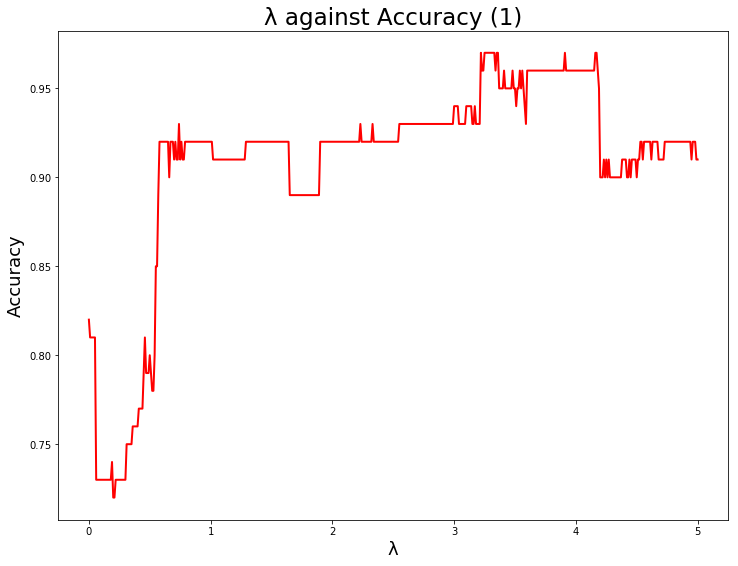

In [150]:
plt.figure(figsize=(12,9))
plt.xlabel('λ', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title('λ against Accuracy (1)', fontsize=23)
plt.plot(lam_list, acc_list, color="red", lw=2)
plt.show()

### Question 12

In [151]:

# Q12
max_index = np.argmax(acc_list)
lam_max = lam_list[max_index]
print(lam_max)



3.2199999999999753


### Question 13

In [153]:
# Q13
c_opt, D_opt, b_opt = get_c_D_b(exp_action, P_a, lam_max, 1.0)
reward_opt = np.array(get_reward(c_opt, D_opt, b_opt))
reward_opt_graph = reward_opt.reshape(10, 10).T



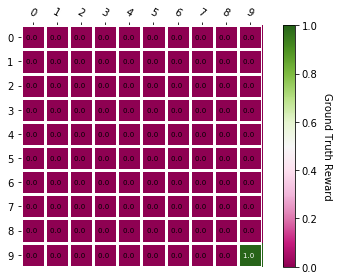

In [162]:
fig, ax = plt.subplots()
x_label = np.arange(10)
y_label = np.arange(10)
                    
im, cbar = heatmap(reward1, x_label, y_label, ax=ax,
                   cmap="PiYG", cbarlabel="Ground Truth Reward")
texts = annotate_heatmap(im, valfmt="{x:.1f} ")

fig.tight_layout()
plt.show()


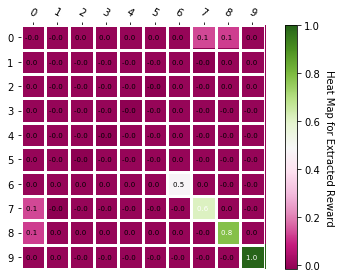

In [163]:
fig, ax = plt.subplots()
x_label = np.arange(10)
y_label = np.arange(10)
                    
im, cbar = heatmap(reward_opt_graph, x_label, y_label, ax=ax,
                   cmap="PiYG", cbarlabel="Heat Map for Extracted Reward")
texts = annotate_heatmap(im, valfmt="{x:.1f} ")

fig.tight_layout()
plt.show()

### Question 14

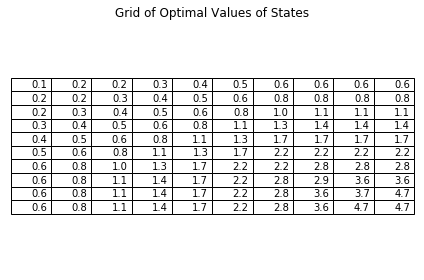

In [164]:

resp  = Expert_Optimal_val(reward_opt,gamma,w,thresh,P_a)
grid = np.round(resp, decimals=3).reshape(10, 10).transpose()
T = [['%.1f' % j for j in i] for i in grid]
fig, ax = plt.subplots()
plt.title("Grid of Optimal Values of States")
plot_grid(T,ax)
fig.tight_layout()
plt.show()

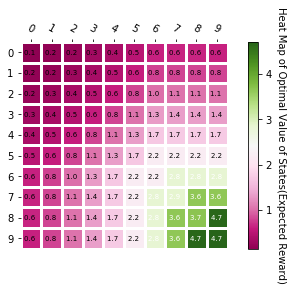

In [165]:
fig, ax = plt.subplots()
x_label = np.arange(np.size(reward1,1))
y_label = np.arange(np.size(reward1,0))
                    
im, cbar = heatmap(grid, x_label, y_label, ax=ax,
                   cmap="PiYG", cbarlabel="Heat Map of Optimal Value of States(Expected Reward)")
texts = annotate_heatmap(im, valfmt="{x:.1f} ")

fig.tight_layout()
plt.show()

### Question 16

In [166]:
exp_action = [0 for _ in range(100)]
for state in range(100):
    exp_action[state] = np.argmax([compute(state, 0, w, gamma, reward_opt, resp,P_a),
                                   compute(state, 1, w, gamma, reward_opt, resp,P_a),
                                   compute(state, 2, w, gamma, reward_opt, resp,P_a),
                                   compute(state, 3, w, gamma, reward_opt, resp,P_a)])

In [171]:
nav_action = get_nav_actions(exp_action)
grid = nav_action.reshape(10, 10).transpose()

fig, ax = plt.subplots()
plt.title("Navigation of Agent across state (Expected Reward)")
plot_grid(grid,ax)
fig.tight_layout()
plt.show()

### Question 18

In [190]:
values = [0 for _ in range(100)]
thresh = 0.01
w = 0.1
gamma = 0.8
P_a = transition_prob(w)

exp_val = Expert_Optimal_val(reward_2,gamma,w,thresh,P_a)
exp_action = [0 for _ in range(100)]
for state in range(100):
    exp_action[state] = np.argmax([compute(state, 0, w, gamma, reward_2, exp_val,P_a),
                                   compute(state, 1, w, gamma, reward_2, exp_val,P_a),
                                   compute(state, 2, w, gamma, reward_2, exp_val,P_a),
                                   compute(state, 3, w, gamma, reward_2, exp_val,P_a)])

lam_list, acc_list = do_sweep(exp_action, P_a,100.0)

lambda: 0  acc: 0.82
lambda: 0.01  acc: 0.8
lambda: 0.02  acc: 0.78
lambda: 0.03  acc: 0.79
lambda: 0.04  acc: 0.78
lambda: 0.05  acc: 0.78
lambda: 0.060000000000000005  acc: 0.8
lambda: 0.07  acc: 0.84
lambda: 0.08  acc: 0.83
lambda: 0.09  acc: 0.83
lambda: 0.09999999999999999  acc: 0.84
lambda: 0.10999999999999999  acc: 0.83
lambda: 0.11999999999999998  acc: 0.81
lambda: 0.12999999999999998  acc: 0.81
lambda: 0.13999999999999999  acc: 0.79
lambda: 0.15  acc: 0.79
lambda: 0.16  acc: 0.81
lambda: 0.17  acc: 0.81
lambda: 0.18000000000000002  acc: 0.82
lambda: 0.19000000000000003  acc: 0.82
lambda: 0.20000000000000004  acc: 0.83
lambda: 0.21000000000000005  acc: 0.82
lambda: 0.22000000000000006  acc: 0.83
lambda: 0.23000000000000007  acc: 0.83
lambda: 0.24000000000000007  acc: 0.83
lambda: 0.25000000000000006  acc: 0.89
lambda: 0.26000000000000006  acc: 0.89
lambda: 0.2700000000000001  acc: 0.88
lambda: 0.2800000000000001  acc: 0.88
lambda: 0.2900000000000001  acc: 0.88
lambda: 0.3000000

lambda: 2.2199999999999966  acc: 0.91
lambda: 2.2299999999999964  acc: 0.91
lambda: 2.239999999999996  acc: 0.91
lambda: 2.249999999999996  acc: 0.9
lambda: 2.259999999999996  acc: 0.9
lambda: 2.2699999999999956  acc: 0.9
lambda: 2.2799999999999954  acc: 0.9
lambda: 2.289999999999995  acc: 0.91
lambda: 2.299999999999995  acc: 0.91
lambda: 2.3099999999999947  acc: 0.89
lambda: 2.3199999999999945  acc: 0.91
lambda: 2.3299999999999943  acc: 0.91
lambda: 2.339999999999994  acc: 0.89
lambda: 2.349999999999994  acc: 0.9
lambda: 2.3599999999999937  acc: 0.91
lambda: 2.3699999999999934  acc: 0.77
lambda: 2.3799999999999932  acc: 0.77
lambda: 2.389999999999993  acc: 0.79
lambda: 2.399999999999993  acc: 0.78
lambda: 2.4099999999999926  acc: 0.78
lambda: 2.4199999999999924  acc: 0.58
lambda: 2.429999999999992  acc: 0.59
lambda: 2.439999999999992  acc: 0.59
lambda: 2.4499999999999917  acc: 0.59
lambda: 2.4599999999999915  acc: 0.56
lambda: 2.4699999999999913  acc: 0.56
lambda: 2.479999999999991  a

lambda: 4.43999999999995  acc: 0.6
lambda: 4.4499999999999496  acc: 0.6
lambda: 4.459999999999949  acc: 0.6
lambda: 4.469999999999949  acc: 0.6
lambda: 4.479999999999949  acc: 0.6
lambda: 4.489999999999949  acc: 0.6
lambda: 4.4999999999999485  acc: 0.6
lambda: 4.509999999999948  acc: 0.6
lambda: 4.519999999999948  acc: 0.61
lambda: 4.529999999999948  acc: 0.61
lambda: 4.539999999999948  acc: 0.61
lambda: 4.549999999999947  acc: 0.61
lambda: 4.559999999999947  acc: 0.61
lambda: 4.569999999999947  acc: 0.61
lambda: 4.579999999999947  acc: 0.61
lambda: 4.589999999999947  acc: 0.61
lambda: 4.599999999999946  acc: 0.61
lambda: 4.609999999999946  acc: 0.61
lambda: 4.619999999999946  acc: 0.61
lambda: 4.629999999999946  acc: 0.61
lambda: 4.6399999999999455  acc: 0.61
lambda: 4.649999999999945  acc: 0.61
lambda: 4.659999999999945  acc: 0.61
lambda: 4.669999999999945  acc: 0.6
lambda: 4.679999999999945  acc: 0.6
lambda: 4.689999999999944  acc: 0.6
lambda: 4.699999999999944  acc: 0.61
lambda: 4.

### Question 19

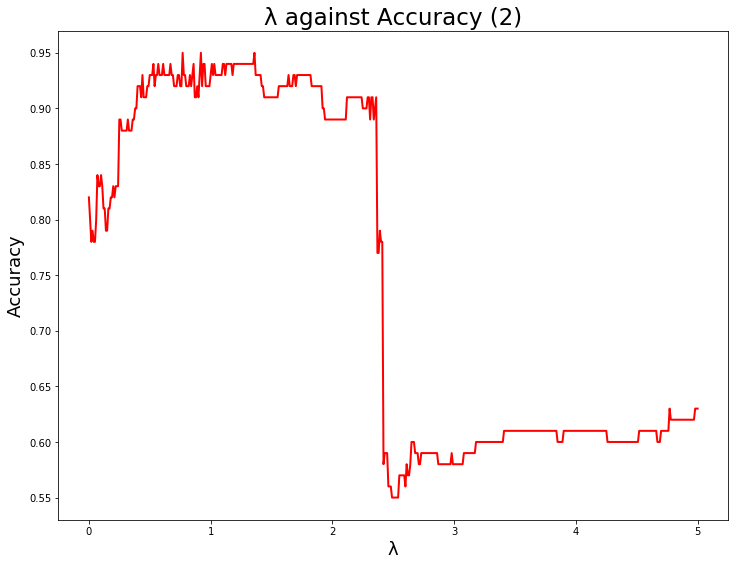

In [191]:
plt.figure(figsize=(12,9))
plt.xlabel('λ', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title('λ against Accuracy (2)', fontsize=23)
plt.plot(lam_list, acc_list, color="red", lw=2)
plt.show()

In [192]:
max_index = np.argmax(acc_list)
lam_max = lam_list[max_index]
print(lam_max)

0.7700000000000005


### Question 20

In [196]:
c_opt, D_opt, b_opt = get_c_D_b(exp_action, P_a, lam_max, 100.0)
reward_opt = np.array(get_reward(c_opt, D_opt, b_opt))
reward_opt_graph = reward_opt.reshape(10, 10).T

In [197]:
fig, ax = plt.subplots()
x_label = np.arange(10)
y_label = np.arange(10)
                    
im, cbar = heatmap(reward2, x_label, y_label, ax=ax,
                   cmap="PiYG", cbarlabel="Ground Truth Reward(2)")
texts = annotate_heatmap(im, valfmt="{x:.1f} ")

fig.tight_layout()
plt.show()

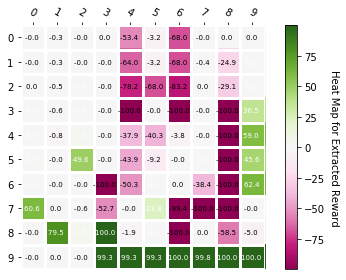

In [198]:
fig, ax = plt.subplots()
x_label = np.arange(10)
y_label = np.arange(10)
                    
im, cbar = heatmap(reward_opt_graph, x_label, y_label, ax=ax,
                   cmap="PiYG", cbarlabel="Heat Map for Extracted Reward")
texts = annotate_heatmap(im, valfmt="{x:.1f} ")

fig.tight_layout()
plt.show()

### Question 21

In [199]:
resp  = Expert_Optimal_val(reward_opt,gamma,w,thresh,P_a)
grid = np.round(resp, decimals=3).reshape(10, 10).transpose()
T = [['%.1f' % j for j in i] for i in grid]
fig, ax = plt.subplots()
plt.title("Grid of Optimal Values of States")
plot_grid(T,ax)
fig.tight_layout()
plt.show()

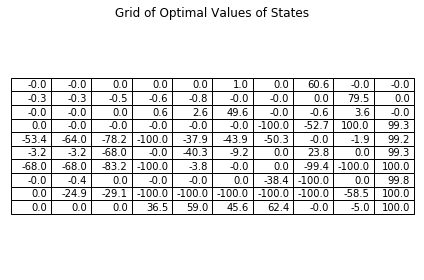

In [216]:
grid_1 = np.round(reward_opt, decimals=3).reshape(10, 10)
T = [['%.1f' % j for j in i] for i in grid_1]
fig, ax = plt.subplots()
plt.title("Grid of Optimal Values of States")
plot_grid(T,ax)
fig.tight_layout()
plt.show()

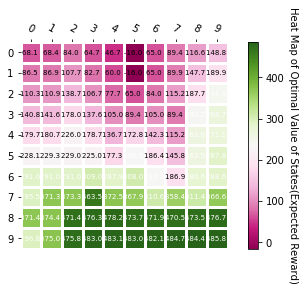

In [200]:
fig, ax = plt.subplots()
x_label = np.arange(np.size(reward1,1))
y_label = np.arange(np.size(reward1,0))
                    
im, cbar = heatmap(grid, x_label, y_label, ax=ax,
                   cmap="PiYG", cbarlabel="Heat Map of Optimal Value of States(Expected Reward)")
texts = annotate_heatmap(im, valfmt="{x:.1f} ")

fig.tight_layout()
plt.show()

### Question 23

In [201]:
exp_action = [0 for _ in range(100)]
for state in range(100):
    exp_action[state] = np.argmax([compute(state, 0, w, gamma, reward_opt, resp,P_a),
                                   compute(state, 1, w, gamma, reward_opt, resp,P_a),
                                   compute(state, 2, w, gamma, reward_opt, resp,P_a),
                                   compute(state, 3, w, gamma, reward_opt, resp,P_a)])

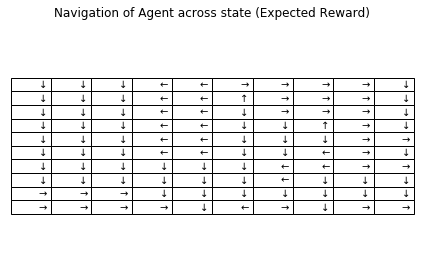

In [202]:
nav_action = get_nav_actions(exp_action)
grid = nav_action.reshape(10, 10).transpose()

fig, ax = plt.subplots()
plt.title("Navigation of Agent across state (Expected Reward)")
plot_grid(grid,ax)
fig.tight_layout()
plt.show()

### Question 25

In [209]:
values = [0 for _ in range(100)]
thresh = 0.00001
w = 0.1
gamma = 0.8
P_a = transition_prob(w)

exp_val = Expert_Optimal_val(reward_2,gamma,w,thresh,P_a)
exp_action = [0 for _ in range(100)]
for state in range(100):
    exp_action[state] = np.argmax([compute(state, 0, w, gamma, reward_2, exp_val,P_a),
                                   compute(state, 1, w, gamma, reward_2, exp_val,P_a),
                                   compute(state, 2, w, gamma, reward_2, exp_val,P_a),
                                   compute(state, 3, w, gamma, reward_2, exp_val,P_a)])

lam_list, acc_list = do_sweep(exp_action, P_a,100.0)

lambda: 0  acc: 0.97
lambda: 0.01  acc: 0.97
lambda: 0.02  acc: 0.87
lambda: 0.03  acc: 0.94
lambda: 0.04  acc: 0.96
lambda: 0.05  acc: 0.84
lambda: 0.060000000000000005  acc: 0.93
lambda: 0.07  acc: 0.92
lambda: 0.08  acc: 0.87
lambda: 0.09  acc: 0.87
lambda: 0.09999999999999999  acc: 0.92
lambda: 0.10999999999999999  acc: 0.87
lambda: 0.11999999999999998  acc: 0.9
lambda: 0.12999999999999998  acc: 0.97
lambda: 0.13999999999999999  acc: 0.9
lambda: 0.15  acc: 0.9
lambda: 0.16  acc: 0.91
lambda: 0.17  acc: 0.88
lambda: 0.18000000000000002  acc: 0.93
lambda: 0.19000000000000003  acc: 0.92
lambda: 0.20000000000000004  acc: 0.97
lambda: 0.21000000000000005  acc: 0.91
lambda: 0.22000000000000006  acc: 0.98
lambda: 0.23000000000000007  acc: 0.98
lambda: 0.24000000000000007  acc: 0.95
lambda: 0.25000000000000006  acc: 0.99
lambda: 0.26000000000000006  acc: 0.98
lambda: 0.2700000000000001  acc: 0.93
lambda: 0.2800000000000001  acc: 0.93
lambda: 0.2900000000000001  acc: 0.92
lambda: 0.30000000

lambda: 2.2199999999999966  acc: 0.93
lambda: 2.2299999999999964  acc: 0.91
lambda: 2.239999999999996  acc: 0.92
lambda: 2.249999999999996  acc: 0.93
lambda: 2.259999999999996  acc: 0.93
lambda: 2.2699999999999956  acc: 0.93
lambda: 2.2799999999999954  acc: 0.92
lambda: 2.289999999999995  acc: 0.93
lambda: 2.299999999999995  acc: 0.93
lambda: 2.3099999999999947  acc: 0.9
lambda: 2.3199999999999945  acc: 0.92
lambda: 2.3299999999999943  acc: 0.92
lambda: 2.339999999999994  acc: 0.9
lambda: 2.349999999999994  acc: 0.91
lambda: 2.3599999999999937  acc: 0.92
lambda: 2.3699999999999934  acc: 0.83
lambda: 2.3799999999999932  acc: 0.79
lambda: 2.389999999999993  acc: 0.91
lambda: 2.399999999999993  acc: 0.84
lambda: 2.4099999999999926  acc: 0.87
lambda: 2.4199999999999924  acc: 0.58
lambda: 2.429999999999992  acc: 0.59
lambda: 2.439999999999992  acc: 0.59
lambda: 2.4499999999999917  acc: 0.59
lambda: 2.4599999999999915  acc: 0.56
lambda: 2.4699999999999913  acc: 0.56
lambda: 2.479999999999991

lambda: 4.43999999999995  acc: 0.6
lambda: 4.4499999999999496  acc: 0.6
lambda: 4.459999999999949  acc: 0.6
lambda: 4.469999999999949  acc: 0.6
lambda: 4.479999999999949  acc: 0.6
lambda: 4.489999999999949  acc: 0.6
lambda: 4.4999999999999485  acc: 0.6
lambda: 4.509999999999948  acc: 0.6
lambda: 4.519999999999948  acc: 0.61
lambda: 4.529999999999948  acc: 0.61
lambda: 4.539999999999948  acc: 0.61
lambda: 4.549999999999947  acc: 0.61
lambda: 4.559999999999947  acc: 0.61
lambda: 4.569999999999947  acc: 0.61
lambda: 4.579999999999947  acc: 0.61
lambda: 4.589999999999947  acc: 0.61
lambda: 4.599999999999946  acc: 0.61
lambda: 4.609999999999946  acc: 0.61
lambda: 4.619999999999946  acc: 0.61
lambda: 4.629999999999946  acc: 0.61
lambda: 4.6399999999999455  acc: 0.61
lambda: 4.649999999999945  acc: 0.61
lambda: 4.659999999999945  acc: 0.61
lambda: 4.669999999999945  acc: 0.6
lambda: 4.679999999999945  acc: 0.6
lambda: 4.689999999999944  acc: 0.6
lambda: 4.699999999999944  acc: 0.61
lambda: 4.

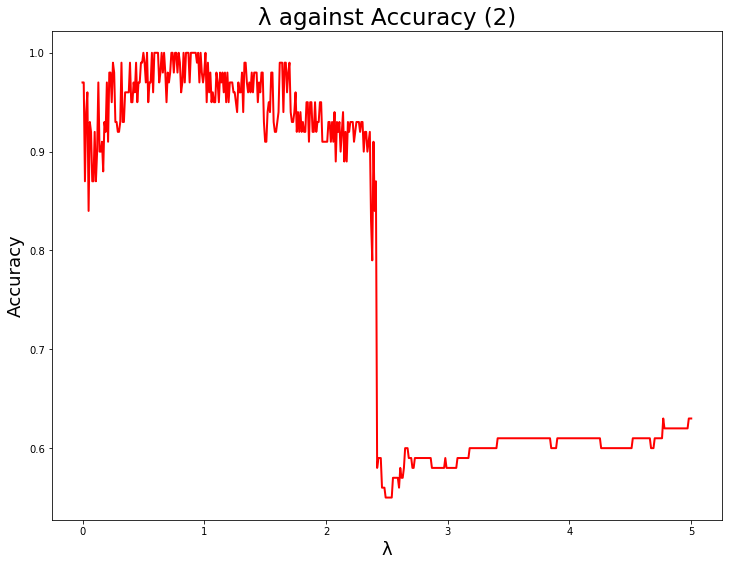

In [210]:
plt.figure(figsize=(12,9))
plt.xlabel('λ', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title('λ against Accuracy (2)', fontsize=23)
plt.plot(lam_list, acc_list, color="red", lw=2)
plt.show()

In [211]:
c_opt, D_opt, b_opt = get_c_D_b(exp_action, P_a, lam_max, 100.0)
reward_opt = np.array(get_reward(c_opt, D_opt, b_opt))
reward_opt_graph = reward_opt.reshape(10, 10).T

In [212]:
resp  = Expert_Optimal_val(reward_opt,gamma,w,thresh,P_a)

In [213]:
exp_action = [0 for _ in range(100)]
for state in range(100):
    exp_action[state] = np.argmax([compute(state, 0, w, gamma, reward_opt, resp,P_a),
                                   compute(state, 1, w, gamma, reward_opt, resp,P_a),
                                   compute(state, 2, w, gamma, reward_opt, resp,P_a),
                                   compute(state, 3, w, gamma, reward_opt, resp,P_a)])

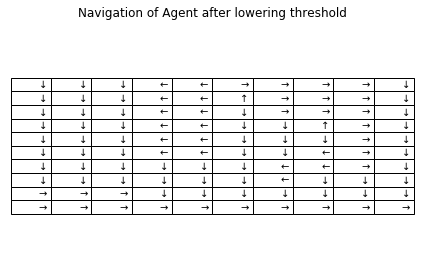

In [214]:
nav_action = get_nav_actions(exp_action)
grid = nav_action.reshape(10, 10).transpose()

fig, ax = plt.subplots()
plt.title("Navigation of Agent after lowering threshold")
plot_grid(grid,ax)
fig.tight_layout()
plt.show()